In [2]:
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.neighbors import kneighbors_graph
import time

import scipy.sparse as sparse
from scipy.stats import multivariate_normal

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger



In [48]:
#generate points
d = 2  #dimension
n = 200 #number of point
n_neighbors = 5

V = np.random.random(n*d).reshape(n,d)
NN = kneighbors_graph(V, n_neighbors, mode='distance').nonzero()
V[0]

array([ 0.60293576,  0.98752706])

In [49]:
NN[1][0:5]
for k in list(NN[1][0:5]): 
    print(V[0])
    print(V[k])

[ 0.60293576  0.98752706]
[ 0.56165639  0.95880401]
[ 0.60293576  0.98752706]
[ 0.54521015  0.95878607]
[ 0.60293576  0.98752706]
[ 0.66847627  0.9478886 ]
[ 0.60293576  0.98752706]
[ 0.67823484  0.94256629]
[ 0.60293576  0.98752706]
[ 0.50971568  0.91077271]


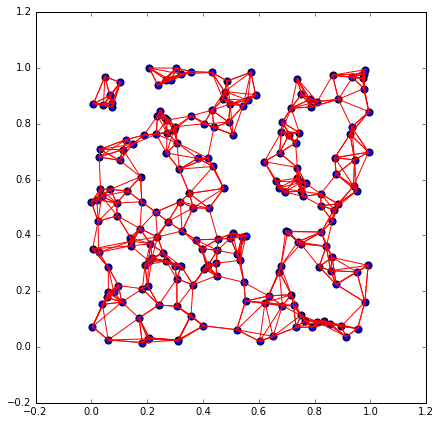

In [13]:
for k in range(n * n_neighbors):
    vertex_start = NN[0][k]
    vertex_end = NN[1][k]
    vertex_start_x = V[vertex_start,0]
    vertex_start_y = V[vertex_start,1]
    vertex_end_x = V[vertex_end,0]
    vertex_end_y = V[vertex_end,1]
    plt.plot([vertex_start_x,vertex_end_x], [vertex_start_y,vertex_end_y], "r-")
    
plt.scatter(V[:,0], V[:,1], s = 50, c="blue")


In [4]:
#create a sparse matrix and put a 1 for each nearest neighbors
Delta = sparse.lil_matrix((n,n))
for k in range(n * n_neighbors):
    Delta[NN[0][k], NN[0][k]] = 1


In [5]:
Delta

<200x200 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in LInked List format>

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import pandas as pd
import math
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats
from sklearn.neighbors import kneighbors_graph
import time

import scipy.sparse as sparse
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger




def hypercube(x_data, y_data, x, n_hc):
    # Some Verif
    if len(x_data) != len(y_data):
        print("data arrays have differents lengths")
    x_data = sorted(x_data)

    # we take an n*log(n) as most values are located
    x_data = x_data * np.log(x_data)
    x = x * np.log(x)
    #plt.plot(x_data, y_data, 'r.')
    #plt.show()
    # Size of datas
    N_data = len(x_data)
    N = len(x)
    delta_hc = np.floor_divide(N_data, n_hc)
    x_data_min = x_data[0]
    x_data_max = x_data[N_data - 1]
    # Lets compute the hypercube output of this data according to a linearspace
    y_hc = np.zeros(n_hc)
    y = np.zeros(N)
    y_hc[0] = np.mean(y_data[0:delta_hc])
    for i in range(1, n_hc - 1):
        y_hc[i] = np.mean(y_data[(i * delta_hc):((i + 1) * delta_hc)])
    y_hc[n_hc - 1] = np.mean(y_data[(n_hc - 1) * delta_hc:])

    for i in range(N):
        p = np.searchsorted(x_data, x[i])
        p = np.floor_divide(p, delta_hc)
        if p == 0:
            y[i] = y_hc[p]
        else:
            y[i] = y_hc[p]
    return y


class BSDE(object):
    
    def __init__(self,S0, K, T, mu, sigma, q):
        ''' 
        
        Parameters
        ==========
        S0             : float
                          positive, initial Stock Value
        mu              : float
                          drift
        K               : float 
                          Strike price
        T               : float 
                          Maturity time 
        sigma           : float 
                          volatility
         Returns
        =======
        BSDE : class
        '''
        self.S0 = S0 
        self.K = K 
        self.T = T
        self.mu = mu
        self.sigma = sigma 
        self.q = q

    def generate_paths(self,r,N,m, mode='delta_B'):
        if mode == 'delta_B':
            dt = self.T / m
            S = np.zeros((m + 1, N))
            dB = np.zeros((m + 1, N))
            S[0] = self.S0
            for t in range(1,m + 1):
                X = np.random.standard_normal(size=N)
                S[t] = S[t - 1] * np.exp((self.mu - self.sigma * self.sigma/2) * dt
                                         + self.sigma * np.sqrt(dt) * X)
                dB[t] =  np.sqrt(dt) * X
            return (S, dB)
        elif mode=='B':
            dt = self.T / m
            S = np.zeros((m + 1, N))
            B = np.zeros((m + 1, N))
            S[0] = self.S0
            for t in range(1, m + 1):
                X = np.random.standard_normal(size=N)
                S[t] = S[t - 1] * np.exp((self.mu - self.sigma * self.sigma / 2) * dt
                                         + self.sigma * np.sqrt(dt) * X)
                B[t] = np.sqrt(t) * X
            return (S, B)


    def get_price_lsm(self, R, r, N, m, K1 = 95., K2 = 105., deg=8, oPayoff = "call", oType = "European", n_picard = 10):
        '''
        Function to generate stock paths.

        Parameters
        ==========
 
        r               : float 
                          lending interest rate 
        R               : float 
                          borrowing interest rate 
        N               : int 
                          Number of paths generated      
        m               : int 
                          number of steps
        d               : int 
                          polynomial fit degree

        Returns
        =======
        Y_opt : float
                Price of the European option
        '''  
        #Time-step
        dt = self.T / m     
        #Discount factor
        df = 1. / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        # S, dB
        S, dB = self.generate_paths(r, N, m)       
        #price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K,0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1,0) - 2 * np.maximum(S[-1] - K2,0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1],0) - 2 * np.maximum(K2 - S[-1],0)


        if (oType == 'European'): 
            #Iteration over time backwardly 
            for t in range (m - 1, 0, -1):            
                X = S[t]
                #Regression for Z
                reg1 = np.polyfit(X, Y * dB[t], deg)
                Z = np.polyval(reg1, X) * (1./ dt)

                #regression for Y
                reg = np.polyfit(X, Y, deg)
                J = np.polyval(reg, X)

                #Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y_inc = df * (J - theta * Z * dt - np.minimum(Y - (1. / self.sigma) * Z, 0) * (R-r) * dt)
                for __ in range(n_picard):
                    reg1  = np.polyfit(X, (Y - Y_inc) * dB[t], deg)
                    Z = np.polyval(reg1, X) * (1. / dt)

                    Y_inc =  df * (J - theta * Z * dt +
                                     np.minimum(Y - (1. / self.sigma) * Z, 0) *
                                     (R-r) * dt)
                Y[:] = Y_inc
                #plt.plot(X, Z, 'r.')
                #plt.show()
            Y_opt= df * np.mean(Y)
        if (oType == 'American'): 
            #Iteration over time backwardly 
            for t in range (m - 1, 0, -1):            
                X = S[t]
                #Regression for Z
                reg1 = np.polyfit(X, Y * dB[t], deg)
                Z = (1./ dt) * np.polyval(reg1, X)
                #print (np.mean( Y * dB[t]) / dt - np.mean(Z), np.std(Z))
                #regression for Y
                reg = np.polyfit(X, Y, deg)
                J = np.polyval(reg, X)
                #Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y = np.maximum(df * (J - theta * Z * dt -
                                     np.minimum(J - (1. / self.sigma) * Z, 0) *
                                     (R-r) * dt), np.maximum(S[t] - self.K, 0))

                #plt.plot(Y,Z, 'r.')
                #plt.show()
            Y_opt= df * np.mean(Y)
            Z_opt = df * np.mean(Z)
            #print (np.mean(Z), np.var(Z))
        return (Y_opt)
    
    def get_price_RF(self, R, r, N, m, K1 = 95., K2 = 105., oPayoff = "call", RF_n_tree = 100, RF_max_leaf_nodes = 15, oType = 'European', n_picard = 10):
        '''
        Get price using Random Forest
        
        Parameters
        ==========
        r               : float 
                          lending interest rate 
        R               : float 
                          borrowing interest rate 
        N               : int 
                          Number of paths generated      
        m               : int 
        
        RF_n_estimators : int 
                          Number of trees generated by the Random Forest regression

        RF_max_leaf_    : int 
        nodes             Maximum number of leafs for every branch of the tree generated
        
        Returns
        =======
        Y_opt : float
                Price of the European option with different interest rates
        '''  
        #Time-step
        dt = self.T / m     
        #Discount factor
        df = 1 / (1 + r * dt)                      
        theta =  -(r - self.mu) / self.sigma
        # S, dB
        S, dB = self.generate_paths(r, N, m)       
        #price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K,0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1,0) - 2 * np.maximum(S[-1] - K2,0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1],0) - 2 * np.maximum(K2 - S[-1],0)

        if (oType == 'European'): 
            
            #Iteration over time backwardly 
            for t in range (m-1, 0, -1):            
                X = S[t]
                X = X[: ,None]
                rf=RandomForestRegressor(n_estimators=RF_n_tree,
                                         max_leaf_nodes=RF_max_leaf_nodes,
                                         oob_score=False, 
                                         n_jobs=-1,
                                         bootstrap= True)


                #Regression for Z
                rf.fit(X, Y * dB[t])
                Z = rf.predict(X) *  (1./ dt)

                #regression for Y
                rf.fit(X, Y)
                J = rf.predict(X)
                #Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y_inc = df * (J - theta * Z * dt -
                                     np.minimum(Y - (1. / self.sigma) * Z, 0) *
                                     (R-r) * dt)

                for __ in range(n_picard):
                    rf.fit(X, (Y - Y_inc) * dB[t])
                    Z = rf.predict(X) * (1. / dt)

                    Y_inc =  df * (J - theta * Z * dt -
                                     np.minimum(Y - (1. / self.sigma) * Z, 0) *
                                     (R-r) * dt)
                Y[:] = Y_inc

            Y_opt= df * np.mean(Y)
            return (Y_opt)
        
        elif (oType == 'American'): 
            #Iteration over time backwardly 
            for t in range (m-1, 0, -1):            
                X = S[t]
                X = X[: ,None]
                rf=RandomForestRegressor(n_estimators=RF_n_tree,
                                         max_leaf_nodes=RF_max_leaf_nodes,
                                         oob_score=False, 
                                         n_jobs=-1)


                #Regression for Z
                rf.fit(X, Y * dB[t])
                Z = rf.predict(X) *  (1./ dt)

                #regression for Y
                rf.fit(X, Y)
                J = rf.predict(X)
                #Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y = np.maximum(df * (J - theta * Z * dt -
                                     np.minimum(Y - (1. / self.sigma) * Z, 0) * 
                                     (R-r) * dt), np.maximum(S[t] - self.K, 0))

            Y_opt= df * sum(Y) / N  
            return (Y_opt)

    def get_price_hc(self, R, r, N, m, K1=95., K2=105., n_hc=20, oPayoff="call", oType="European", n_picard=0):
        '''
        Function to generate stock paths.

        Parameters
        ==========

        r               : float
                          lending interest rate
        R               : float
                          borrowing interest rate
        N               : int
                          Number of paths generated
        m               : int
                          number of steps
        d               : int
                          polynomial fit degree

        Returns
        =======
        Y_opt : float
                Price of the European option
        '''
        # Time-step
        dt = self.T / m
        # Discount factor
        df = 1. / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        # S, dB
        S, dB = self.generate_paths(r, N, m)
        # price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K, 0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1, 0) - 2 * np.maximum(S[-1] - K2, 0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1], 0) - 2 * np.maximum(K2 - S[-1], 0)

        if (oType == 'European'):
            # Iteration over time backwardly
            for t in range(m - 1, 0, -1):
                X = S[t]
                # Regression for Z
                #Z = hypercube(X, Y * dB[t], X, n_hc)* (1. / dt)
                #plt.plot(X,Y,'r.')
                #plt.show()
                Z = np.interp(X, X, Y * dB[t]) * 1 / dt
                # regression for Y
                J = np.interp(X, X, Y)
                #J = hypercube(X, Y, X, n_hc)

                # Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y_inc = df * (J - theta * Z * dt - np.minimum(Y - (1. / self.sigma) * Z, 0) * (R - r) * dt)
                for __ in range(n_picard):
                    Z = hypercube(X, (Y - Y_inc) * dB[t], X, n_hc) * (1. / dt)

                    Y_inc = df * (J - theta * Z * dt +
                                  np.minimum(Y - (1. / self.sigma) * Z, 0) *
                                  (R - r) * dt)
                Y[:] = Y_inc
                # plt.plot(X, Z, 'r.')
                # plt.show()
            Y_opt = df * np.mean(Y)
        if (oType == 'American'):
            # Iteration over time backwardly
            for t in range(m - 1, 0, -1):
                X = S[t]
                # Regression for Z
                Z = self.hypercube(X, Y * dB[t], X, n_hc)

                # regression for Y
                J = self.hypercube(X, Y, X, n_hc)

                # Y = np.polyval(reg,X)-Y*r*dt-theta*Z*dt+np.minimum(Y-(1/sigma)*Z,0)*(R-r)*dt
                Y = np.maximum(df * (J - theta * Z * dt -
                                     np.minimum(J - (1. / self.sigma) * Z, 0) *
                                     (R - r) * dt), np.maximum(S[t] - self.K, 0))

                # plt.plot(Y,Z, 'r.')
                # plt.show()
            Y_opt = df * np.mean(Y)
            Z_opt = df * np.mean(Z)
            # print (np.mean(Z), np.var(Z))
        return (Y_opt)

    def get_cva(self, N, m,r, RF_n_tree, RF_max_leaf_nodes, beta):
        # Time-step
        dt = self.T / m
        #beta = lambda_c * (1 - R)
        # S, dB
        S, dB = self.generate_paths(r, N, m)
        # Iteration over the paths"
        f = lambda x: 1 if x > 1 else 0
        Y = np.zeros(N)
        for i in range (N):
            Y[i] = 1 - 2 * f(S[- 1, i])

        for t in range(m - 1, 0, -1):
            X = S[t]
            X = X[: ,None]
            rf=RandomForestRegressor(n_estimators=RF_n_tree,
                                     max_leaf_nodes=RF_max_leaf_nodes,
                                     oob_score=False,
                                     n_jobs=-1,
                                     bootstrap= True)

            #regression for Y
            rf.fit(X, Y)
            J = rf.predict(X)
            for i in range (N):
                Y[i] = 1 / (1 + beta * dt * (1 - f(J[i] + 1))) * J[i]

        Y_opt = np.mean(Y)
        return (Y_opt)

    def get_price_mesh(self, N, m, r, R, n_neighbors = 10,  K1=95., K2=105., oPayoff="call", oType="European", n_picard=0):
        # Time-step
        dt = self.T / m
        # Discount factor
        df = 1 / (1 + r * dt)
        theta = -(r - self.mu) / self.sigma
        a = (r - 0.5 * self.sigma ** 2) * dt
        c = self.sigma * np.sqrt(dt)
        # S, dB
        S, B = self.generate_paths(r, N, m, mode='B')
        # price of the option at time T = Initialization for a call
        if oPayoff == "call":
            Y = np.maximum(S[-1] - self.K, 0)
        elif oPayoff == "put":
            Y = np.maximum(self.K - S[-1], 0)
        elif oPayoff == "call combination":
            Y = np.maximum(S[-1] - K1, 0) - 2 * np.maximum(S[-1] - K2, 0)
        elif oPayoff == "put combination":
            Y = np.maximum(K1 - S[-1], 0) - 2 * np.maximum(K2 - S[-1], 0)

        if (oType == 'European'):

            # Iteration over time backwardly
            for t in range(m - 1, 0, -1):
                Z = np.zeros(N)
                data = S[t + 1].reshape(N, 1)
                NN = kneighbors_graph(data, n_neighbors,
                                      mode='distance').nonzero()
                # regression for Z
                W = np.zeros([N, n_neighbors])
                sequence_neighbors = []
                for j in range (N):
                    # n_neighbors_of_j = [NN[1][k] for k in range(N * n_neighbors) if NN[0][k] == j]
                    # sequence_neighbors.append(n_neighbors_of_j)
                    for k in range(n_neighbors):
                        W[j, k] = (1 / (S[t + 1, NN[1][j + k]] * self.sigma * np.sqrt(dt))) * norm.pdf(
                            (np.log(S[t + 1, k] / S[t, j]) - a) / c)


                for k in range(n_neighbors):
                    W[:, k] = W[:, k] / np.sum(W[:, k])

                for j in range(N):
                    Z[j] = 1 / dt * np.sum(
                        np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))]) *
                        np.array([(B[t + 1, [NN[1][k]]] - B[t, j]) for k in range(j, j + n_neighbors)]) * W[j, :])
                    Y[j] = df * (np.sum(
                        np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))]) * W[j, :]) - theta * dt * Z[j] - np.minimum(
                        Y[j] - (1. / self.sigma) * Z[j], 0) *
                                 (R - r) * dt)
                # for __ in range(n_picard):
                #     rf.fit(X, (Y - Y_inc) * dB[t])
                #     Z = rf.predict(X) * (1. / dt)
                #
                #     Y_inc = df * (J - theta * Z * dt -
                #                   np.minimum(Y - (1. / self.sigma) * Z, 0) *
                #                   (R - r) * dt)

            Y_opt = df * np.mean(Y)
            return (Y_opt)




In [130]:
T = 0.5
m = 6
K = 100
S0 = 100
sigma = 0.2
r = 0.04
N = 25
mu = 0.06
R = 0.06
q = 0.
RF_n_trees = 100
RF_max_leaf_nodes = 50

test = BSDE(S0, K, T, mu, sigma, q)

In [131]:
test.get_price_mesh(N, m , R, r)

-0.07588798141523255

In [70]:
 # Time-step
dt = test.T / m
# Discount factor
df = 1 / (1 + r * dt)
theta = -(r - test.mu) / test.sigma
a = (r - 0.5 * test.sigma ** 2) * dt
c = test.sigma * np.sqrt(dt)
# S, dB
S, B = test.generate_paths(r, N, m, mode='B')

In [78]:
Y = np.maximum(S[-1] - test.K, 0)

In [79]:
Z = np.zeros(N)
NN = kneighbors_graph(np.array([list(S[4]), list(Y * (B[5, :] - B[4,:]))]).reshape(N, 2), n_neighbors, mode='distance').nonzero()

In [89]:
# regression for Z
n_neighbors = 10
W = np.zeros([N, N])
for j in range (N):
#     for k in range(n_neighbors):
#         W[j, k] = (1 / (S[5, NN[1][j + k]] * test.sigma * np.sqrt(dt))) * norm.pdf(
#             (np.log(S[5, k] / S[4, j]) - a) / c)
    for k in range(N): 
        W[j, k] = (1 / (S[5, k] * test.sigma * np.sqrt(dt))) * norm.pdf((np.log(S[5, k] / S[4, j]) - a) / c)

In [81]:
for j in range(N):
    Z[j] = 1 / dt * np.sum(
        np.array([Y[NN[1][k]] for k in range(j, (j + n_neighbors))]) *
        np.array([(B[5, NN[1][k]] - B[4, j]) for k in range(j, (j + n_neighbors))]) * W[j, :])
    Y[j] = df * (sum(
        [Y[NN[1][k]] for k in range(j, (j + n_neighbors))] * W[j, :]) - theta * dt * Z[j] - np.minimum(
        Y[j] - (1. / test.sigma) * Z[j], 0) *
                 (R - r) * dt)
    

In [82]:
Y

array([ 1.07035688,  3.63907688,  1.66618355,  0.2328579 ,  1.53868327,
        1.10938744,  0.71858807,  0.87092051,  1.47443079,  1.84272238,
        0.67736487,  0.32532564,  0.24348438,  0.0338323 ,  0.10660985,
        0.01208834,  0.1024341 ,  0.41983912,  0.26589518,  0.38080039,
        0.07771477,  0.48977362,  0.14252072,  0.02596191,  0.07060789])

In [128]:
data = np.array(S[4]).reshape(N, 1)
NN = kneighbors_graph(data, n_neighbors,
                                      mode='distance').nonzero()

In [112]:
NN

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
        15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
        22, 

AttributeError: 'tuple' object has no attribute 'shape'

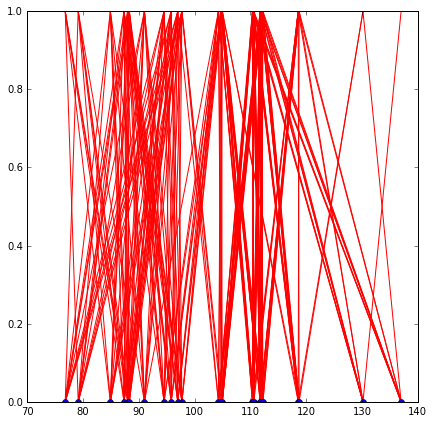

In [121]:
for k in range(N* n_neighbors):
    vertex_start = NN[0][k]
    vertex_end = NN[1][k]
    vertex_start_x = data[vertex_start]
    vertex_start_y = 0.
    vertex_end_x = data[vertex_end]
    vertex_end_y = 1.
    plt.plot([vertex_start_x,vertex_end_x], [vertex_start_y,vertex_end_y], "r-")
    
#plt.scatter(V[:,0], V[:,1], s = 50, c="blue")
plt.plot(data, [0 for k in range(len(data))], "bo")
plt.show()

In [53]:
V = np.array([list(S[4]), list(S[5])]).reshape(N, 2)

In [91]:
for k in range(N):
    W[:, k] = W[:, k] / np.sum(W[:, k])

In [96]:
np.sum(W[:, 7])

1.0

In [108]:
Z = 1 / dt * np.sum(Y * (B[5, :] - B[4, j]) * W[j, :])
Y = df * (np.sum(Y* W[j, :]) - theta * dt * Z - np.minimum(
        Y - (1. / test.sigma) * Z, 0) *
                 (R - r) * dt)
    

In [109]:
Y

array([ 0.18002016,  0.18002016,  0.18002016,  0.18002016,  0.18002016,
        0.18002016,  0.18002016,  0.18002016,  0.18002016,  0.18002016,
        0.18002016,  0.18002016,  0.18002016,  0.18002016,  0.18002016,
        0.18002016,  0.18002016,  0.18002016,  0.18002016,  0.18002016,
        0.18002016,  0.18002016,  0.18002016,  0.18002016,  0.18002016])